/Users/liuliangjie/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[*********************100%***********************]  1 of 1 completed


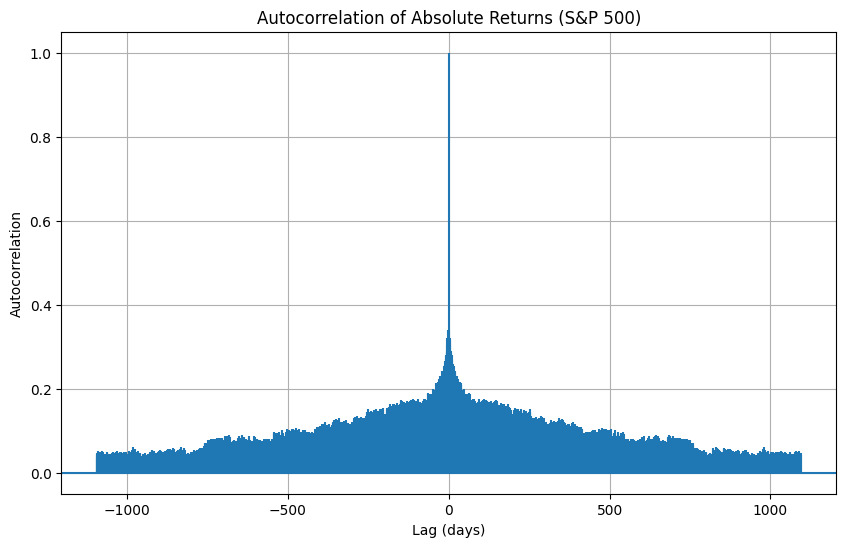

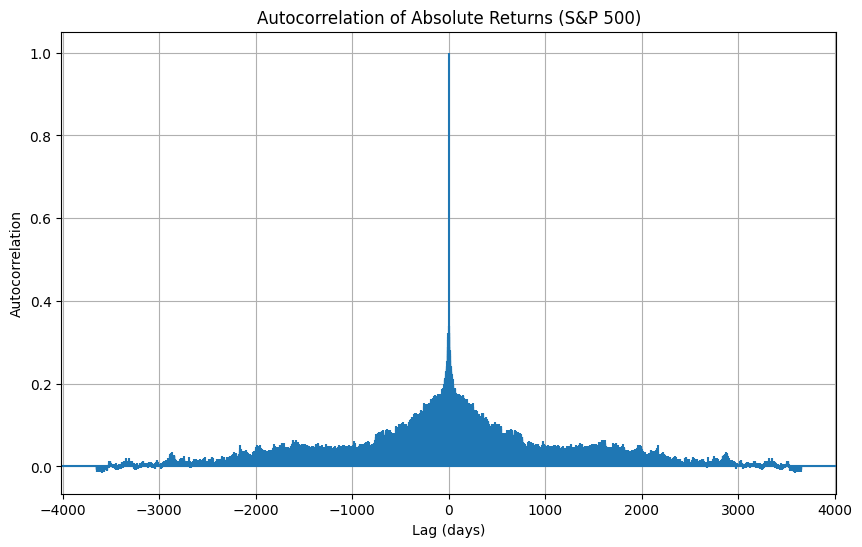

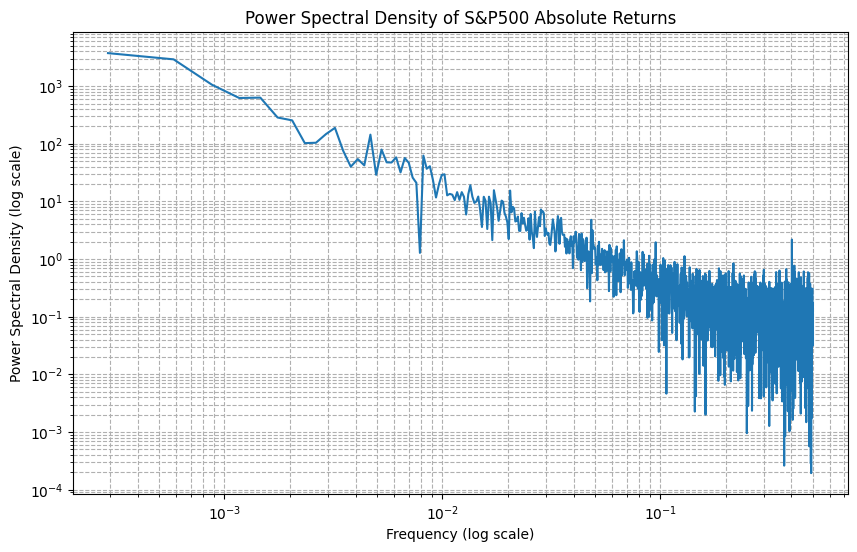

Low Frequency Beta: 1.6827438745833845
High Frequency Beta: 0.2604815560495817
Average Frequency Beta: 1.3966057845854014


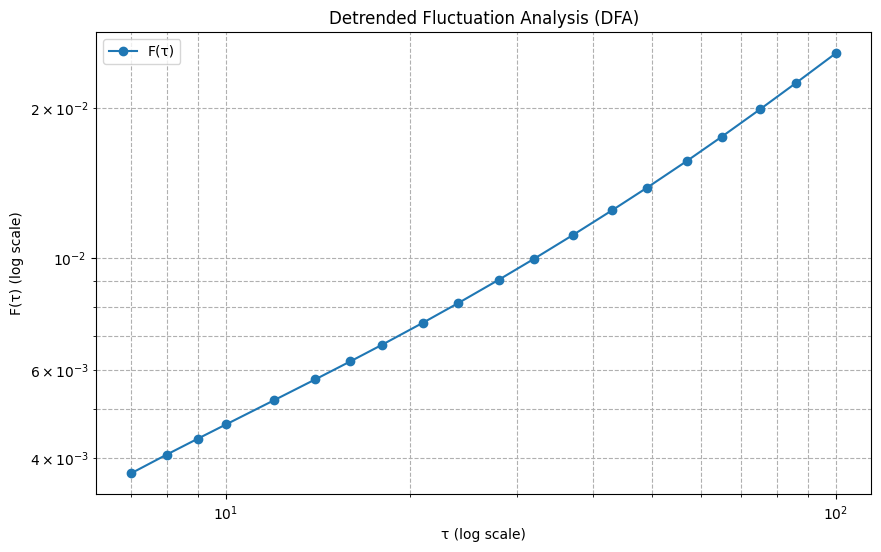

Fitted α: 0.7155002028304226
Calculated β: 0.4310004056608452


In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: 下载数据
ticker = "^GSPC"
start_date = "1927-12-30"
end_date = "2024-11-01"
data = yf.download(ticker, start=start_date, end=end_date)

# Step 2: 数据清理
data = data.dropna()
# Step 3: 计算绝对收益率
adj_close = data['Adj Close']
absolute_returns = abs(adj_close.pct_change())
absolute_returns = absolute_returns.dropna()

# Step 4: 减去均值
adjusted_returns = absolute_returns - absolute_returns.mean()

adjusted_returns_series = adjusted_returns.iloc[:, 0]  # 提取第一列作为 Series
adjusted_returns_array = adjusted_returns_series.values

plt.figure(figsize=(10, 6))
plt.acorr(adjusted_returns_array, maxlags=365*3)  # 最大滞后时间为 3 年
plt.title("Autocorrelation of Absolute Returns (S&P 500)")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.acorr(adjusted_returns_array, maxlags=365*10)  # 最大滞后时间为 10 年
plt.title("Autocorrelation of Absolute Returns (S&P 500)")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.fftpack import fft

# Step 1: 计算自相关
autocorr = [adjusted_returns_series.autocorr(lag=i) for i in range(1, 365*10)]  # 365*10 是十年最大滞后
autocorr = np.array(autocorr)  # 转换为 NumPy 数组

# 提取非负分支
non_negative_branch = autocorr[autocorr >= 0]

# Step 2: 计算功率谱密度
psd = np.abs(fft(non_negative_branch))**2
freqs = np.fft.fftfreq(len(non_negative_branch), d=1)[:len(non_negative_branch)//2]
psd = psd[:len(non_negative_branch)//2]

# Step 3: 绘制对数坐标功率谱密度
plt.figure(figsize=(10, 6))
plt.loglog(freqs[freqs > 0], psd[freqs > 0])  # 忽略负频率
plt.title("Power Spectral Density of S&P500 Absolute Returns")
plt.xlabel("Frequency (log scale)")
plt.ylabel("Power Spectral Density (log scale)")
plt.grid(True, which="both", linestyle="--")
plt.show()

# Step 4: 拟合低频和高频
log_freqs = np.log10(freqs[freqs > 0])
log_psd = np.log10(psd[freqs > 0])

split_index = len(log_freqs) // 2  # 分为低频和高频
low_freq = log_freqs[:split_index]
low_psd = log_psd[:split_index]
high_freq = log_freqs[split_index:]
high_psd = log_psd[split_index:]

# 低频拟合
low_model = LinearRegression()
low_model.fit(low_freq.reshape(-1, 1), low_psd)
low_beta = -low_model.coef_[0]

# 高频拟合
high_model = LinearRegression()
high_model.fit(high_freq.reshape(-1, 1), high_psd)
high_beta = -high_model.coef_[0]

#平均情况
average_model = LinearRegression()
average_model.fit(log_freqs.reshape(-1, 1), log_psd)
average_beta = -average_model.coef_[0]

print(f"Low Frequency Beta: {low_beta}")
print(f"High Frequency Beta: {high_beta}")
print(f"Average Frequency Beta: {average_beta}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ===================== Step a: 生成累积和序列 =====================
def cumulative_sum(series):
    mean_adjusted = series - np.mean(series)
    return np.cumsum(mean_adjusted)

cumulative_series = cumulative_sum(adjusted_returns_series)

# ===================== Step b: 滑动窗口方法 =====================
def sliding_window(series, tau):
    T = len(series)
    segments = [series[i:i + tau] for i in range(T - tau + 1)]
    return segments

# ===================== Step c: 去趋势波动计算 =====================
def detrended_fluctuation(segment):
    n = len(segment)
    x = np.arange(n)
    y = segment

    # 计算均值和二次统计量
    mean_x = (n - 1) / 2
    mean_x2 = (n - 1) * (2 * n - 1) / 6

    mean_y = np.mean(y)
    mean_xy = np.dot(x, y) / n

    # 计算 RMS 差值
    epsilon = np.sqrt(np.mean(y**2) - mean_y**2 - (mean_xy - mean_x * mean_y)**2 / (mean_x2 - mean_x**2))
    return epsilon

# ===================== Step d: 计算 F(τ) 和绘图 =====================
def calculate_F(series, taus):
    F_tau = []
    for tau in taus:
        segments = sliding_window(series, tau)
        rms_values = [detrended_fluctuation(segment) for segment in segments]
        F_tau.append(np.mean(rms_values))
    return np.array(F_tau)

# 定义窗口大小（以对数间隔选择 tau）
taus = [int(10**x) for x in np.linspace(np.log10(7), np.log10(100), 20)]
F_tau = calculate_F(cumulative_series, taus)

# 绘制 F(τ) 图
plt.figure(figsize=(10, 6))
plt.loglog(taus, F_tau, 'o-', label="F(τ)")
plt.title("Detrended Fluctuation Analysis (DFA)")
plt.xlabel("τ (log scale)")
plt.ylabel("F(τ) (log scale)")
plt.grid(True, which="both", linestyle="--")
plt.legend()
plt.show()

# ===================== Step e: 拟合幂律指数 α =====================
log_taus = np.log10(taus)
log_F_tau = np.log10(F_tau)

model = LinearRegression()
model.fit(log_taus.reshape(-1, 1), log_F_tau)
alpha = model.coef_[0]

print(f"Fitted α: {alpha}")

# ===================== Step f: 验证 β = 2α - 1 =====================
beta = 2 * alpha - 1
print(f"Calculated β: {beta}")